## Pobranie potrzebnych paczek

In [57]:
import requests
import os
from pyunpack import Archive
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
from py7zr import unpack_7zarchive
import matplotlib.pyplot as plt

## Funkcje potrzebne do pobrania i przygotowania danych

In [58]:
def download_packed(url, name, path):
    filename = path + '\\' + name + '.7z'
    if os.path.exists(filename):
        return filename
    
    response = requests.get(url, stream=True)
    if not os.path.exists(path):
        os.mkdir(path)
    if response.status_code == 200:
        with open(filename, 'wb') as out:
            out.write(response.content)
    else:
        print(f'Request failed with code {response.status_code}')
    return filename

In [59]:
def download_all_packed(urls, names, path):
    filenames = []
    for url, name in zip(urls, names):
        filenames.append(download_packed(url, name, path))
    return filenames

In [60]:
def unpack(archive, path):
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        return archive[:-3]
    shutil.unpack_archive(archive, path)
    return archive[:-3]

In [61]:
def unpack_all(archives, path, names):
    files = []
    for archive, name in zip(archives, names):
        files.append(unpack(archive, path + '\\' + name))
    return files

In [62]:
def parse_xml(file, tables):
    data = {}
    for table in tables:
        tree = et.parse(file + '\\' + table + '.xml')
        root = tree.getroot()
        rows = []
        for elem in root:
            rows.append(elem.attrib)
        data[table] = pd.DataFrame(rows)
    return data

In [63]:
def parse_all_xml(files, names, tables):
    dataframes = {}
    for file, name in zip(files, names):
        dataframes[name] = parse_xml(file, tables)
    return dataframes

In [64]:
def adjust_data(df):
    boolean_dict = {'False':False, 'True':True, np.nan:False}
    for col in df:
        if ('Id' in col) or (col == 'Score') or (col == 'Class') or ('Count' in col) or \
        (col == 'Reputation') or ('Views' in col) or ('Votes' in col):
            df[col] = pd.to_numeric(df[col])
        elif ('Date' in col):
            df[col] = pd.to_datetime(df[col])
        elif (col == 'TagBased') or ('Is' in col):
            df[col] = df[col].map(boolean_dict)
    return df

In [65]:
def adjust_all_data(dfs):
    for key in dfs:
        for inner_key in dfs[key]:
            dfs[key][inner_key] = adjust_data(dfs[key][inner_key])
    return dfs

In [66]:
def prepare_data_for_use(urls, names, path, tables):
    archives = download_all_packed(urls, names, path)
    files = unpack_all(archives, path, names)
    dataframes = parse_all_xml(files, names, tables)
    dataframes_adjusted = adjust_all_data(dataframes)
    return dataframes_adjusted

## Wywołanie utworzenia danych

In [67]:
urls = [
    'https://archive.org/download/stackexchange/islam.stackexchange.com.7z',
    'https://archive.org/download/stackexchange/christianity.stackexchange.com.7z',
    'https://archive.org/download/stackexchange/buddhism.stackexchange.com.7z',
    'https://archive.org/download/stackexchange/judaism.stackexchange.com.7z',
    'https://archive.org/download/stackexchange/hinduism.stackexchange.com.7z',
]

names = [
    'islam',
    'christianity',
    'buddhism',
    'judaism',
    'hinduism'
]

tables = [
    'Badges',
    'Comments',
    'PostHistory',
    'PostLinks',
    'Posts',
    'Users',
    'Votes',
    'Tags',
    
]

path = os.getcwd() + '\\' + 'data'

dfs = prepare_data_for_use(urls, names, path, tables)

islam_df = dfs['islam']
christianity_df = dfs['christianity']
buddhism_df = dfs['buddhism']
judaism_df = dfs['judaism']
hinduism_df = dfs['hinduism']

 ## Stosunek postów do miesięcy

In [75]:
def get_posts_per_month(df):
    data = df['Posts'].groupby([df['Posts'].CreationDate.dt.month])['CreationDate'].count()
    return data

In [76]:
m1 = get_posts_per_month(islam_df)
m2 = get_posts_per_month(christianity_df)
m3 = get_posts_per_month(buddhism_df)
m4 = get_posts_per_month(judaism_df)
m5 = get_posts_per_month(hinduism_df)

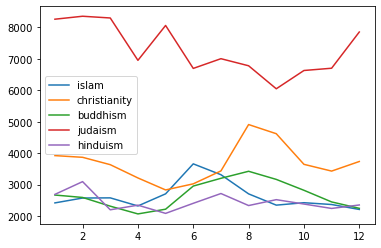

In [79]:
plt.plot(m1)
plt.plot(m2)
plt.plot(m3)
plt.plot(m4)
plt.plot(m5)

plt.legend([
    'islam',
    'christianity',
    'buddhism',
    'judaism',
    'hinduism'
])

plt.show()